# Imports

In [1156]:
!pip install chart-studio
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
!pip install prophet
# Facebook's Prophet forecasting library
from prophet import Prophet

# Standard plotly imports
import chart_studio.plotly.plotly as py
from plotly import graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Pulling the data

In [1157]:
# Read in the raw temperature and emissions datasets (they are in CSV format)
raw_t = pd.read_csv('./sample_data/GLB.Ts+dSST.csv', skiprows=1)
raw_e = pd.read_csv('./sample_data/API_EN.ATM.CO2E.PC_DS2_en_csv_v2_10515380.csv', skiprows=3)

In [1158]:
# Investigate how the raw data looks
raw_t.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.29,-0.18,-.11,-.19,-.11,-.23,-.21,-.09,-.16,-.23,-.20,-.22,-.18,***,***,-.14,-.18,-.19
1,1881,-0.15,-0.17,.04,.04,.02,-.20,-.06,-.02,-.13,-.20,-.21,-.10,-.09,-.10,-.18,.04,-.09,-.18
2,1882,0.15,0.15,.04,-.18,-.15,-.25,-.20,-.05,-.10,-.24,-.15,-.24,-.10,-.09,.07,-.10,-.17,-.16
3,1883,-0.31,-0.38,-.12,-.16,-.19,-.12,-.08,-.15,-.20,-.14,-.22,-.15,-.19,-.19,-.31,-.16,-.11,-.19
4,1884,-0.15,-0.08,-.37,-.42,-.36,-.40,-.34,-.26,-.27,-.24,-.29,-.28,-.29,-.28,-.13,-.38,-.33,-.27


In [1159]:
raw_e.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,NaN,NaN,NaN,NaN,NaN,NaN,...,24.670529,24.505835,13.155542,8.351294,8.408363,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.046060,0.053604,0.073765,0.074233,0.086292,0.101467,...,0.293837,0.412017,0.350371,0.315602,0.299445,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,0.097472,0.079038,0.201289,0.192535,0.201003,0.191528,...,1.243406,1.252789,1.330843,1.254617,1.291328,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1.258195,1.374186,1.439956,1.181681,1.111742,1.166099,...,1.578574,1.803715,1.692908,1.749211,1.978763,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,NaN,NaN,NaN,NaN,NaN,NaN,...,6.122595,5.867130,5.916597,5.900753,5.832170,NaN,NaN,NaN,NaN,NaN


# Wrangling Time Series Data

## Wrangling Temperature

In [1160]:
# Create new dataframe with an index for each month
# First create the date range
date_rng = pd.date_range(start='1/1/1880', end='1/03/2019', freq='M')

type(date_rng[0])
### returns
### pandas._libs.tslibs.timestamps.Timestamp

# Next create the empty DataFrame, which we will populate using the actual data
t = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the anomoly values
t['Avg_Anomaly_deg_C'] = None

# Set the index of the DataFrame to the date column (DateTime index)
t.set_index('date', inplace=True)

# Show the first few elements
t.head()

,Avg_Anomaly_deg_C
date,
1880-01-31,None
1880-02-29,None
1880-03-31,None
1880-04-30,None
1880-05-31,None


In [1161]:
# We only want the monthly data, lets only select that and leave out the seasonal columns
raw_t = raw_t.iloc[:,:13]
raw_t.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1880,-0.29,-0.18,-.11,-.19,-.11,-.23,-.21,-.09,-.16,-.23,-.20,-.22
1,1881,-0.15,-0.17,.04,.04,.02,-.20,-.06,-.02,-.13,-.20,-.21,-.10
2,1882,0.15,0.15,.04,-.18,-.15,-.25,-.20,-.05,-.10,-.24,-.15,-.24
3,1883,-0.31,-0.38,-.12,-.16,-.19,-.12,-.08,-.15,-.20,-.14,-.22,-.15
4,1884,-0.15,-0.08,-.37,-.42,-.36,-.40,-.34,-.26,-.27,-.24,-.29,-.28


In [1162]:
# Import relevant libraries
import calendar
from datetime import datetime

# Function definition
def populate_df_with_anomolies_from_row(row):
    year = row['Year']
    # Anomaly values (they seem to be a mixture of strings and floats)
    monthly_anomolies = row.iloc[1:]
    # Abbreviated month names (index names)
    months = monthly_anomolies.index
    for month in monthly_anomolies.index:
        # Get the last day for each month
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate)
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # Populate / set value @ above index, to anomaly value
        t.loc[date_index] = monthly_anomolies[month]

# Apply function to each row of raw data
_ = raw_t.apply(lambda row: populate_df_with_anomolies_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
t.head()

,Avg_Anomaly_deg_C
date,
1880-01-31,-0.29
1880-02-29,-0.18
1880-03-31,-.11
1880-04-30,-.19
1880-05-31,-.11


In [1163]:
# Import Numpy, as library meant for large arrays - we will use it that we
import numpy as np

# Define function to convert values to floats, and return a 'NaN = Not a Number' if this is not possible
def clean_anomaly_value(raw_value):
    try:
        return float(raw_value)
    except:
        return np.NaN

# Apply above function to all anomaly values in DataFrame
t['Avg_Anomaly_deg_C'] = t['Avg_Anomaly_deg_C'].apply(lambda raw_value: clean_anomaly_value(raw_value))

# 'Forward fill' to take care of NaN values
t.fillna(method='ffill', inplace=True)

# Show the first few elements of our newly cleaned DataFrame
t.head()

,Avg_Anomaly_deg_C
date,
1880-01-31,-0.29
1880-02-29,-0.18
1880-03-31,-0.11
1880-04-30,-0.19
1880-05-31,-0.11


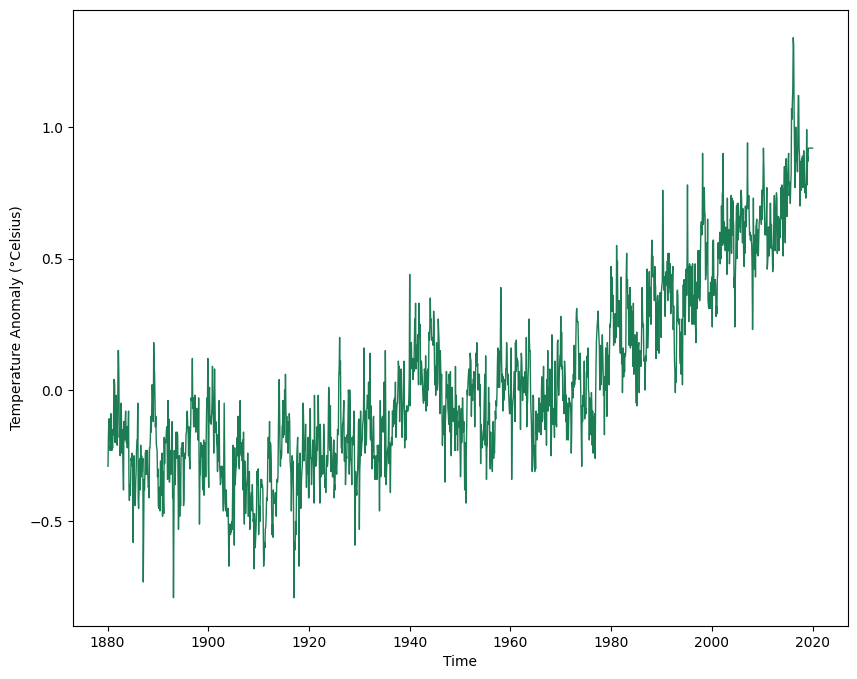

In [1164]:
# Plot the data - quick and easy - using matplotlib, we will draw prettier graphs later

# Import Matplotlib
import matplotlib.pyplot as plt
# Allow for rendering within notebook
%matplotlib inline

# Create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t, color='#1C7C54', linewidth=1.0)

In [1165]:
# The data can be resampled to a different frequency,
# lets resample it to years (end-of-year):
t.resample('A').mean().head()

,Avg_Anomaly_deg_C
date,
1880-12-31,-0.185000
1881-12-31,-0.095000
1882-12-31,-0.101667
1883-12-31,-0.185000
1884-12-31,-0.288333


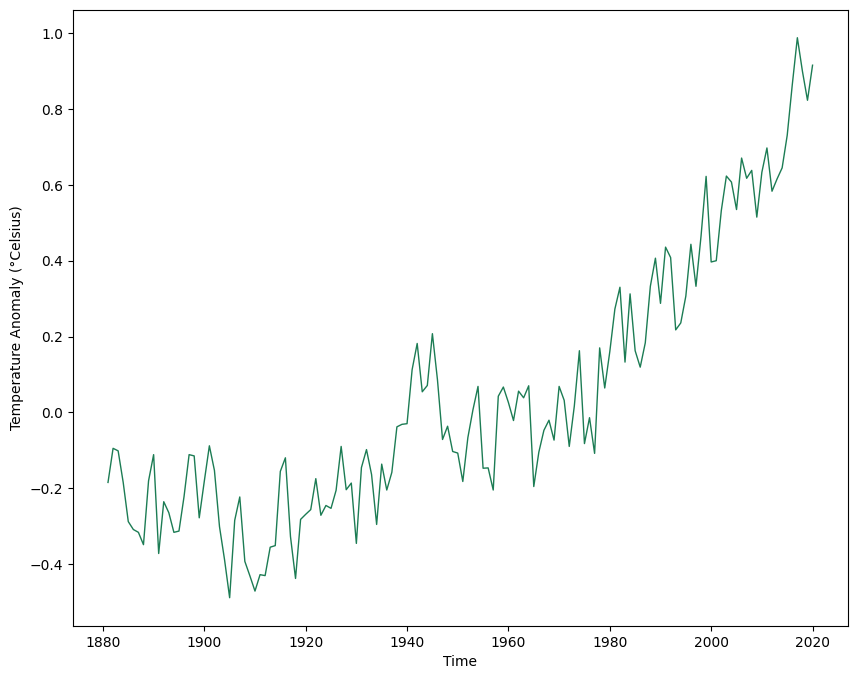

In [1166]:
# Now lets visualize our resampled DataFrame

# Import Matplotlib
import matplotlib.pyplot as plt
# Allow for rendering within notebook
%matplotlib inline
# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t.resample('A').mean(), color='#1C7C54', linewidth=1.0)

## Wrangling Emissions

In [1167]:
# Illustrate how the above DataFrame can be filtered for values after 2011
e[e.index.year>2011]

,Global CO2 Emissions per Capita
date,
2012-12-31,4.996211
2013-12-31,4.987739
2014-12-31,4.969974
2015-12-31,4.969974
2016-12-31,4.969974
2017-12-31,4.969974
2018-12-31,4.969974


In [1168]:
# Deal with the NaNs by 'forward filling'
e.fillna(method='ffill', inplace=True)

In [1169]:
# Check that there are no longer NaNs at the end
e[e.index.year>2011]

,Global CO2 Emissions per Capita
date,
2012-12-31,4.996211
2013-12-31,4.987739
2014-12-31,4.969974
2015-12-31,4.969974
2016-12-31,4.969974
2017-12-31,4.969974
2018-12-31,4.969974


In [1170]:
e['1984-01-04':'1990-01-06']

,Global CO2 Emissions per Capita
date,
1984-12-31,4.019671
1985-12-31,4.068895
1986-12-31,4.118996
1987-12-31,4.146842
1988-12-31,4.221216
1989-12-31,4.238247


# Final DataFrames

In [1171]:
# Temperature anomalies
t.head()

,Avg_Anomaly_deg_C
date,
1880-01-31,-0.29
1880-02-29,-0.18
1880-03-31,-0.11
1880-04-30,-0.19
1880-05-31,-0.11


In [1172]:
# Temperature anomalies resampled to end-of-year
t.resample('A').mean().head()

,Avg_Anomaly_deg_C
date,
1880-12-31,-0.185000
1881-12-31,-0.095000
1882-12-31,-0.101667
1883-12-31,-0.185000
1884-12-31,-0.288333


In [1173]:
# CO2 emissions
e.head()

,Global CO2 Emissions per Capita
date,
1960-12-31,3.099013
1961-12-31,3.069727
1962-12-31,3.140511
1963-12-31,3.244499
1964-12-31,3.360596


# Visualizing Time Series Data

## Plotting Temperature with Matplotlib

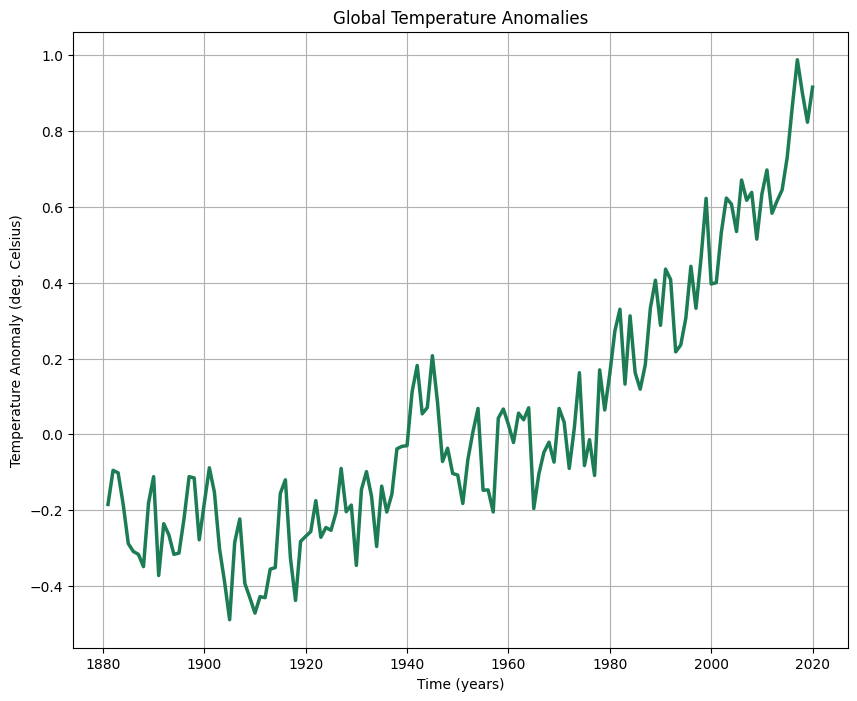

In [1174]:
# import Matplotlib
import matplotlib.pyplot as plt
# Allow for graphs to be displayed in Jupyter notebook
%matplotlib inline

# Resample or temperature data to years (end-of-year)
t_resampled = t.resample('A').mean()

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot temperature data with specific colour and line thickness
ax.plot(t_resampled, color='#1C7C54', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (years)', ylabel='Temperature Anomaly (deg. Celsius)',
       title='Global Temperature Anomalies')

# Enable grid
ax.grid()


## Plotting Emissions with Matplotlib

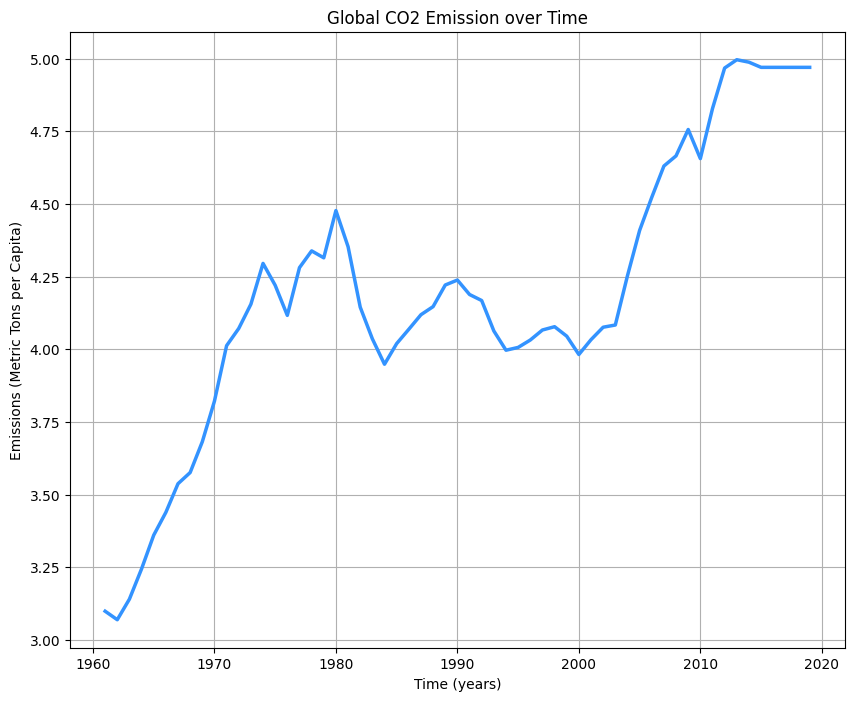

In [1175]:
# import Matplotlib
import matplotlib.pyplot as plt
# Allow for graphs to be displayed in Jupyter notebook
%matplotlib inline

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot co2 emissions data with specific colour and line thickness
ax.plot(e, color='#3393FF', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (years)', ylabel='Emissions (Metric Tons per Capita)',
       title='Global CO2 Emission over Time')

# Enable grid
ax.grid()

## Plotting Temperature with Plotly

In [1176]:
# Standard plotly imports
#import chart_studio.plotly.plotly as py
#import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [1177]:
t.resample('A').mean().iplot(kind='line', xTitle='Time (years)', color='#1C7C54',
                  yTitle='Temperature Anomaly (deg. Celsius)', title='Global Temperature Anomalies')

## Plotting Emissions with Plotly

In [1178]:
e.iplot(kind='line', xTitle='Time (years)', color='#3393FF',
                  yTitle='Emissions (Metric Tons per Capita)', title='Global CO2 Emission over Time')

# Timeseries Correlation

## Granger Causality

In [1179]:
from statsmodels.tsa.stattools import grangercausalitytests

# Filter the temperature and emissions data for the desired years (1960-2018)
#temperature = t.resample('A')  #.loc['1960-01-31':'2018-12-31']
temperature = t.loc['1960-01-31':'2018-12-31', 'Avg_Anomaly_deg_C'].resample('A').mean()

emissions = e.loc['1960-01-31':'2018-12-31']

# Convert the data to numpy arrays
temperature_array = temperature.to_numpy()
emissions_array = emissions.to_numpy()

# Check the shape of the arrays
print(temperature)
print(emissions)

# Perform the Granger causality test
result = grangercausalitytests(np.column_stack((temperature_array, emissions_array)), maxlag=2)

# Print the results
for lag in result.keys():
    print(f"Lag Order = {lag}")
    print(f"Granger Causality p-value = {result[lag][0]['ssr_ftest'][1]}")





date
1960-12-31   -0.021667
1961-12-31    0.055833
1962-12-31    0.038333
1963-12-31    0.070000
1964-12-31   -0.195833
1965-12-31   -0.105000
1966-12-31   -0.047500
1967-12-31   -0.020833
1968-12-31   -0.073333
1969-12-31    0.068333
1970-12-31    0.031667
1971-12-31   -0.090000
1972-12-31    0.016667
1973-12-31    0.162500
1974-12-31   -0.082500
1975-12-31   -0.014167
1976-12-31   -0.108333
1977-12-31    0.170000
1978-12-31    0.064167
1979-12-31    0.160000
1980-12-31    0.272500
1981-12-31    0.330000
1982-12-31    0.132500
1983-12-31    0.312500
1984-12-31    0.162500
1985-12-31    0.119167
1986-12-31    0.183333
1987-12-31    0.332500
1988-12-31    0.406667
1989-12-31    0.287500
1990-12-31    0.435833
1991-12-31    0.408333
1992-12-31    0.217500
1993-12-31    0.235833
1994-12-31    0.306667
1995-12-31    0.443333
1996-12-31    0.332500
1997-12-31    0.465000
1998-12-31    0.622500
1999-12-31    0.396667
2000-12-31    0.400000
2001-12-31    0.532500
2002-12-31    0.623333
2003-1

## Dynamic Time Warping

In [1180]:
# The above will be available in another post soon! The post will also use these same two time series.

# Time Series Modelling and Forecasting

## Facebook Prophet

In [1181]:
t_prophet = pd.DataFrame()
t_prophet['ds'] = t.index
t_prophet['y'] = t['Avg_Anomaly_deg_C'].values

In [1182]:
m = Prophet()
m.fit(t_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs___r5/pxua0d1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bs___r5/ou5xnzv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82689', 'data', 'file=/tmp/tmp4bs___r5/pxua0d1s.json', 'init=/tmp/tmp4bs___r5/ou5xnzv9.json', 'output', 'file=/tmp/tmp4bs___r5/prophet_modelu3kws9j7/prophet_model-20230709235911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:59:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [1183]:
# Make future dataframes
future = m.make_future_dataframe(freq='m', periods=100*12)
forecast = m.predict(future)

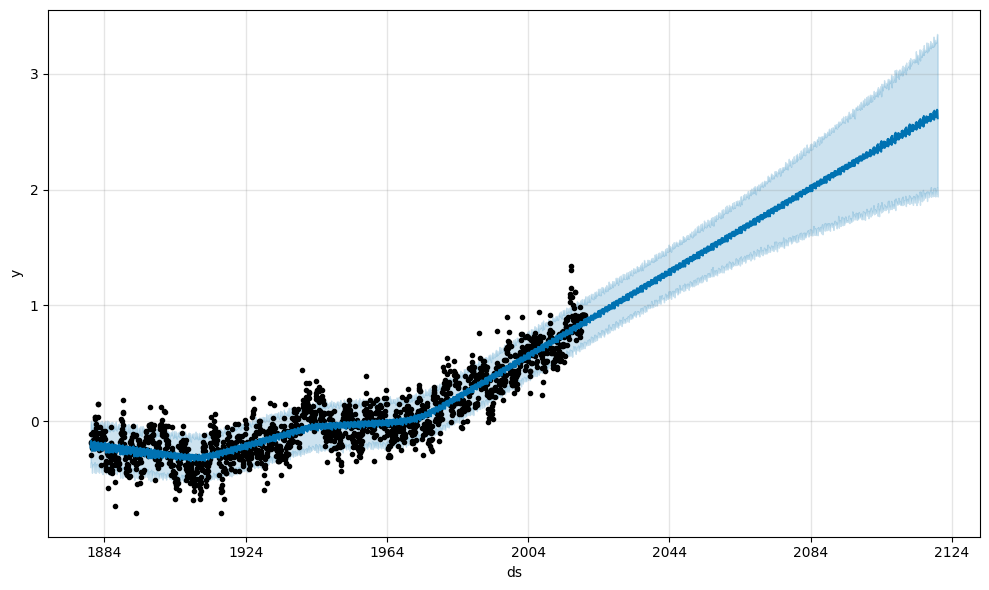

In [1184]:
m.plot(forecast);

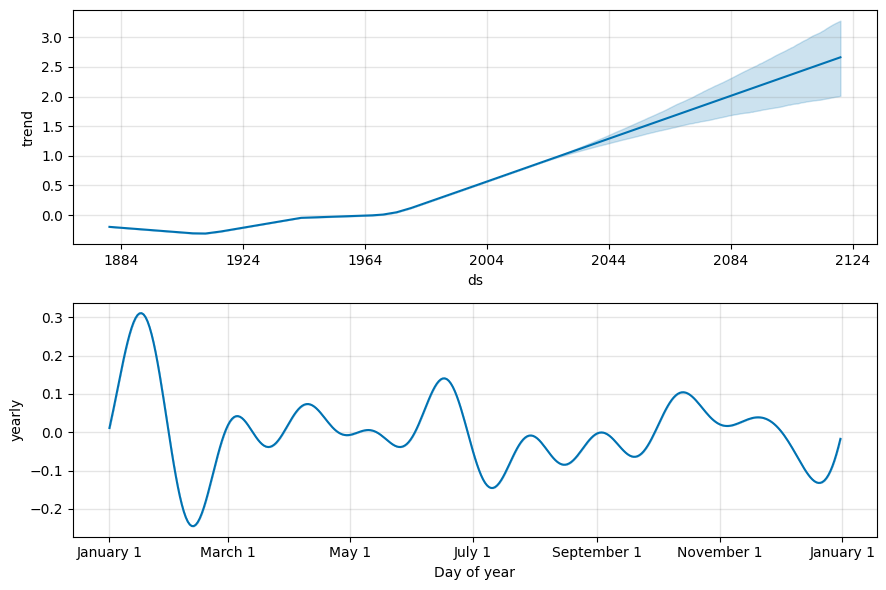

In [1185]:
m.plot_components(forecast);

## Autoregressive Integrated Moving Average (ARIMA)

In [1186]:
# This will also be available in a future post

# THE END